In [1]:
from python_workflow_definition.aiida import write_workflow_json
from python_workflow_definition.jobflow import load_workflow_json
from jobflow.managers.local import run_locally

from aiida import load_profile
load_profile()

workflow_json_filename =  "aiida_to_pyiron_base_qe.json"

/srv/conda/envs/notebook/lib/python3.12/site-packages/paramiko/pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  "cipher": algorithms.TripleDES,
/srv/conda/envs/notebook/lib/python3.12/site-packages/paramiko/transport.py:253: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  "class": algorithms.TripleDES,


In [2]:
from aiida_workgraph import task, WorkGraph
from typing import Any

In [3]:
# NOTE: `get_dict` is `get_input_dict`, to compile the input values for the calc tasks
# NOTE: `add_link` must be from outputs to inputs
from python_workflow_definition.shared import get_dict, get_list

In [4]:
@task.pythonjob()
def pickle_node(value):
    """Handle data nodes"""
    return value

In [5]:
from quantum_espresso_workflow import generate_structures as _generate_structures
from quantum_espresso_workflow import get_bulk_structure as _get_bulk_structure
from quantum_espresso_workflow import calculate_qe as _calculate_qe
from quantum_espresso_workflow import plot_energy_volume_curve as _plot_energy_volume_curve

In [6]:
strain_lst = [0.9, 0.95, 1.0, 1.05, 1.1]

In [7]:
get_bulk_structure = task.pythonjob()(_get_bulk_structure)
generate_structures = task.pythonjob()(_generate_structures)
calculate_qe = task.pythonjob(outputs=["energy", "volume", "structure"])(
    _calculate_qe
)
plot_energy_volume_curve = task.pythonjob()(_plot_energy_volume_curve)

In [8]:
wg = WorkGraph("wg-qe")

In [9]:
pickle_element_task = wg.add_task(
    pickle_node,
    name="pickle_element",
    value="Al",
)

In [10]:
pickle_a_task = wg.add_task(
    pickle_node, name="pickle_a", value=4.05
)

In [11]:
pickle_cubic_task = wg.add_task(
    pickle_node, name="pickle_cubic", value=True
)

In [12]:
pickle_relax_workdir_task = wg.add_task(
    pickle_node,
    name="pickle_relax_workdir",
    value="mini",
)

In [13]:
# ? relax or SCF, or general? -> Should be relax
relax_get_dict_task = wg.add_task(
    task.pythonjob(
        # outputs=["structure", "calculation", "kpts", "pseudopotentials", "smearing"]
        # outputs=["dict"]
    )(get_dict),
    name="relax_get_dict",
    register_pickle_by_value=True,
)

In [14]:
pickle_pp_task = wg.add_task(
    pickle_node,
    name="pseudopotentials",
    value={"Al": "Al.pbe-n-kjpaw_psl.1.0.0.UPF"},
)

In [15]:
pickle_kpts_task = wg.add_task(
    pickle_node, name="kpts_task", value=[3, 3, 3]  # FIXME: Back to [3, 3, 3]
)

In [16]:
pickle_calc_type_relax_task = wg.add_task(
    pickle_node,
    name="calc_type_relax",
    value="vc-relax",
)

In [17]:
pickle_smearing_task = wg.add_task(
    pickle_node, name="smearing", value=0.02
)

In [18]:
strain_lst_task = wg.add_task(
    pickle_node,
    name="pickle_strain_lst",
    value=strain_lst,
)

In [19]:
get_bulk_structure_task = wg.add_task(
    get_bulk_structure,
    name="get_bulk_structure",
    register_pickle_by_value=True,
)

In [20]:
relax_task = wg.add_task(
    calculate_qe,
    # ! I don't like the `mini` name...
    name="mini",
    register_pickle_by_value=True,
)

In [21]:
generate_structures_task = wg.add_task(
    generate_structures,
    name="generate_structures",
    register_pickle_by_value=True,
)

In [22]:
# here we add the structure outputs based on the number of strains
del wg.tasks.generate_structures.outputs["result"]

In [23]:
scf_qe_tasks = []
for i, strain in enumerate(strain_lst):
    generate_structures_task.add_output("workgraph.any", f"s_{i}")

    scf_qe_task = wg.add_task(
        calculate_qe,
        name=f"qe_{i}",
        register_pickle_by_value=True,
    )
    scf_qe_tasks.append(scf_qe_task)

In [24]:
plot_energy_volume_curve_task = wg.add_task(
    plot_energy_volume_curve,
    name="plot_energy_volume_curve",
    register_pickle_by_value=True,
)

In [25]:
strain_dir_tasks, scf_get_dict_tasks = [], []
for i, strain in enumerate(strain_lst):
    strain_dir = f"strain_{i}"

    strain_dir_task = wg.add_task(
        pickle_node,
        name=f"pickle_{strain_dir}_dir",
        value=strain_dir,
        register_pickle_by_value=True,
    )
    strain_dir_tasks.append(strain_dir_task)

    scf_get_dict_task = wg.add_task(
        task.pythonjob()(get_dict),
        name=f"get_dict_{i}",
        register_pickle_by_value=True,
    )
    scf_get_dict_tasks.append(scf_get_dict_task)

    if i == 0:
        pickle_calc_type_scf_task = wg.add_task(
            pickle_node,
            name="calc_type_scf",
            value="scf",
        )

In [26]:
get_volumes_task = wg.add_task(
    task.pythonjob()(get_list),
    name="get_volumes",
    register_pickle_by_value=True,
)

In [27]:
get_energies_task = wg.add_task(
    task.pythonjob()(get_list),
    name="get_energies",
    register_pickle_by_value=True,
)

In [28]:
# Add remaining links
wg.add_link(
    pickle_element_task.outputs.result, get_bulk_structure_task.inputs.element
)
wg.add_link(pickle_a_task.outputs.result, get_bulk_structure_task.inputs.a)
wg.add_link(pickle_cubic_task.outputs.result, get_bulk_structure_task.inputs.cubic)

NodeLink(from="pickle_cubic.result", to="get_bulk_structure.cubic")

In [29]:
# `.set` rather than `.add_link`, as get_dict takes `**kwargs` as input
relax_get_dict_task.set(
    {
        "structure": get_bulk_structure_task.outputs.result,
        "calculation": pickle_calc_type_relax_task.outputs.result,
        "kpts": pickle_kpts_task.outputs.result,
        "pseudopotentials": pickle_pp_task.outputs.result,
        "smearing": pickle_smearing_task.outputs.result,
    }
)

In [30]:
wg.add_link(relax_get_dict_task.outputs.result, relax_task.inputs.input_dict)
wg.add_link(
    pickle_relax_workdir_task.outputs.result,
    relax_task.inputs.working_directory,
)

NodeLink(from="pickle_relax_workdir.result", to="mini.working_directory")

In [31]:
wg.add_link(relax_task.outputs.structure, generate_structures_task.inputs.structure)
wg.add_link(
    strain_lst_task.outputs.result, generate_structures_task.inputs.strain_lst
)

NodeLink(from="pickle_strain_lst.result", to="generate_structures.strain_lst")

In [32]:
for i, (scf_get_dict_task, scf_qe_task, strain_dir_task) in enumerate(
    list(zip(scf_get_dict_tasks, scf_qe_tasks, strain_dir_tasks))
):
    scf_get_dict_task.set(
        {
            "structure": generate_structures_task.outputs[f"s_{i}"],
            "calculation": pickle_calc_type_scf_task.outputs.result,
            "kpts": pickle_kpts_task.outputs.result,
            "pseudopotentials": pickle_pp_task.outputs.result,
            "smearing": pickle_smearing_task.outputs.result,
        }
    )
    wg.add_link(scf_get_dict_task.outputs.result, scf_qe_task.inputs.input_dict)
    wg.add_link(
        strain_dir_task.outputs.result, scf_qe_task.inputs.working_directory
    )

    # collect energy and volume
    # wg.add_link(scf_qe_task.outputs.energy, get_energies_task.inputs.kwargs)
    get_energies_task.set({f"{i}": scf_qe_task.outputs.energy})
    # wg.add_link(scf_qe_task.outputs.volume, get_volumes_task.inputs.kwargs)
    get_volumes_task.set({f"{i}": scf_qe_task.outputs.volume})

In [33]:
wg.add_link(
    get_volumes_task.outputs.result,
    plot_energy_volume_curve_task.inputs.volume_lst,
)

NodeLink(from="get_volumes.result", to="plot_energy_volume_curve.volume_lst")

In [34]:
wg.add_link(
    get_energies_task.outputs.result,
    plot_energy_volume_curve_task.inputs.energy_lst,
)

NodeLink(from="get_energies.result", to="plot_energy_volume_curve.energy_lst")

In [35]:
_ = write_workflow_json(wg=wg, file_name=workflow_json_filename)


In [36]:
flow = load_workflow_json(file_name=workflow_json_filename)

2025-03-21 21:26:20,046 INFO Started executing jobs locally
2025-03-21 21:26:20,183 INFO Starting job - get_bulk_structure (fabb0d01-2442-4557-bd4e-b5ead7cf98d0)
2025-03-21 21:26:20,186 INFO Finished job - get_bulk_structure (fabb0d01-2442-4557-bd4e-b5ead7cf98d0)
2025-03-21 21:26:20,187 INFO Starting job - get_dict (612b1bb6-d593-4435-9b3d-5bb269ad2843)
2025-03-21 21:26:20,189 INFO Finished job - get_dict (612b1bb6-d593-4435-9b3d-5bb269ad2843)
2025-03-21 21:26:20,190 INFO Starting job - calculate_qe (f21e58fb-0abd-4b50-bc40-b0ed2fe1f9ee)


[jupyter-pyiron-dev-pyth-flow-definition-fqg29pgr:00221] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


2025-03-21 21:27:11,297 INFO Finished job - calculate_qe (f21e58fb-0abd-4b50-bc40-b0ed2fe1f9ee)
2025-03-21 21:27:11,299 INFO Starting job - generate_structures (5ad4c3c2-9398-448d-b647-97b367ee2cf5)
2025-03-21 21:27:11,303 INFO Finished job - generate_structures (5ad4c3c2-9398-448d-b647-97b367ee2cf5)
2025-03-21 21:27:11,304 INFO Starting job - get_dict (d7b594b9-6ac6-474d-9c52-c8ee5fcdd8b4)
2025-03-21 21:27:11,305 INFO Finished job - get_dict (d7b594b9-6ac6-474d-9c52-c8ee5fcdd8b4)
2025-03-21 21:27:11,307 INFO Starting job - get_dict (fb9a4ee5-331f-408d-880d-9cd0d91acf0c)
2025-03-21 21:27:11,308 INFO Finished job - get_dict (fb9a4ee5-331f-408d-880d-9cd0d91acf0c)
2025-03-21 21:27:11,309 INFO Starting job - get_dict (12b26f9e-fb15-4c25-a2fc-b2d6ffa530ee)
2025-03-21 21:27:11,311 INFO Finished job - get_dict (12b26f9e-fb15-4c25-a2fc-b2d6ffa530ee)
2025-03-21 21:27:11,311 INFO Starting job - get_dict (b41cc69e-4168-4d6c-ab7b-fd3a4cefc9d7)
2025-03-21 21:27:11,313 INFO Finished job - get_dict (

[jupyter-pyiron-dev-pyth-flow-definition-fqg29pgr:00236] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


2025-03-21 21:27:21,677 INFO Finished job - calculate_qe (7f7ed5dd-7756-4185-bc23-3dc77775c365)
2025-03-21 21:27:21,678 INFO Starting job - calculate_qe (145ab651-febe-43af-97ef-310d48ce2d71)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
[jupyter-pyiron-dev-pyth-flow-definition-fqg29pgr:00247] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


2025-03-21 21:27:32,158 INFO Finished job - calculate_qe (145ab651-febe-43af-97ef-310d48ce2d71)
2025-03-21 21:27:32,159 INFO Starting job - calculate_qe (b2f6f779-980a-4b0e-be32-9fda29034214)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
[jupyter-pyiron-dev-pyth-flow-definition-fqg29pgr:00258] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


2025-03-21 21:27:44,722 INFO Finished job - calculate_qe (b2f6f779-980a-4b0e-be32-9fda29034214)
2025-03-21 21:27:44,723 INFO Starting job - calculate_qe (6856f4da-485b-4d5a-852e-ca70b7d333ea)


[jupyter-pyiron-dev-pyth-flow-definition-fqg29pgr:00269] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


2025-03-21 21:27:57,827 INFO Finished job - calculate_qe (6856f4da-485b-4d5a-852e-ca70b7d333ea)
2025-03-21 21:27:57,829 INFO Starting job - calculate_qe (ed56e21c-8b54-40cb-928a-a36f9ca8346d)


[jupyter-pyiron-dev-pyth-flow-definition-fqg29pgr:00281] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


2025-03-21 21:28:11,262 INFO Finished job - calculate_qe (ed56e21c-8b54-40cb-928a-a36f9ca8346d)
2025-03-21 21:28:11,264 INFO Starting job - get_list (1533cc3f-f189-40c0-9489-e6249e87f464)
2025-03-21 21:28:11,267 INFO Finished job - get_list (1533cc3f-f189-40c0-9489-e6249e87f464)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


2025-03-21 21:28:11,268 INFO Starting job - get_list (033d92b6-3b26-4732-9c1e-d29317f562f0)
2025-03-21 21:28:11,271 INFO Finished job - get_list (033d92b6-3b26-4732-9c1e-d29317f562f0)
2025-03-21 21:28:11,272 INFO Starting job - plot_energy_volume_curve (25f4b44b-532d-4a35-a8ef-c0faa55091d7)
2025-03-21 21:28:11,391 INFO Finished job - plot_energy_volume_curve (25f4b44b-532d-4a35-a8ef-c0faa55091d7)
2025-03-21 21:28:11,392 INFO Finished executing jobs locally


{'fabb0d01-2442-4557-bd4e-b5ead7cf98d0': {1: Response(output='{"immutable_id": null, "last_modified": null, "elements": ["Al"], "nelements": 1, "elements_ratios": [1.0], "chemical_formula_descriptive": "Al4", "chemical_formula_reduced": "Al", "chemical_formula_hill": null, "chemical_formula_anonymous": "A", "dimension_types": [1, 1, 1], "nperiodic_dimensions": 3, "lattice_vectors": [[4.05, 0.0, 0.0], [0.0, 4.05, 0.0], [0.0, 0.0, 4.05]], "space_group_symmetry_operations_xyz": null, "space_group_symbol_hall": null, "space_group_symbol_hermann_mauguin": null, "space_group_symbol_hermann_mauguin_extended": null, "space_group_it_number": null, "cartesian_site_positions": [[0.0, 0.0, 0.0], [0.0, 2.025, 2.025], [2.025, 0.0, 2.025], [2.025, 2.025, 0.0]], "nsites": 4, "species": [{"name": "Al", "chemical_symbols": ["Al"], "concentration": [1.0], "mass": null, "original_name": null, "attached": null, "nattached": null}], "species_at_sites": ["Al", "Al", "Al", "Al"], "assemblies": null, "structur

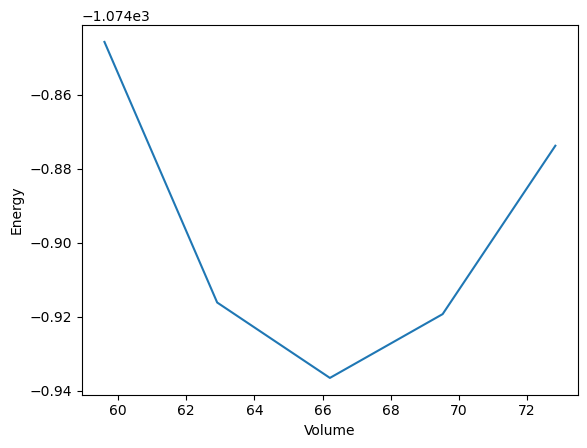

In [37]:
result = run_locally(flow)
result